## Dhruv Ragunathan

### Contact Information
* Linkedin: https://www.linkedin.com/in/dhruv-ragunathan-908993b1/
* Github: https://github.com/dragunat2016
  
### Presentation Date: November 20, 2023
## Table of Contents

* [Overview](#Overview)<br>
* [Business Objectives](#Business-Objectives)<br>
* [Data Overview](#Data-Overview)<br>
* [Data Preparation](#Data-Preparation)<br>
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
* [Modeling](#Modeling)<br>
* [Final Model Evaluation](#Evaluation)<br>
* [Recommendations](#Recommendations)<br>
* [Future Projects](#Further-Inquiry)<br>
* [Reproduction Steps](#Reproduction-Steps)<br>

# Overview

!['BRFSS_Call_Center](images/BRFSS_Image.jpeg)

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collects state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. 

Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

Researchers have seen the opportunity to apply machine learning algorithms to make predictions on the data, since it was a feature rich dataset with hundreds-of-thousands of records.



# Business Objectives

!['BRFSS_Trade_Mark](images/BRFSS_TM_Img.jpeg)

We have been tasked by the CDC to create models from previous BRFSS data that predicts diabetes. The CDC wants to help the people it surveys and alert them if they are at risk for diabetes given their survey results. Long-term the CDC would like to publish an application to Americans allowing them to fill out a form with questions on their vitals like BMI and habits such as exercise. Upon completing the form, the CDC would send back a diabetic risk to the person.

The motivation behind this is that diabetes is one of the most prevalent and costly diseases in the USA. Currently, 38 million people have diabetes of which 9 million are undiagnosed. When considering the precursor, prediabetes, that number jumps to 98 million people.

Diabetic patients are more likely to visit the emergency department and require expensive treatments and medications for their life. Reducing diabetes across the country would greatly improve the quality of life of millions of Americans.

Accuracy and precision are our primary metrics of evaluation. Accuracy defines the number of correct predictions made by the model over the total number of predictions. Precision defines the number of True positive identified over the true positive plus the false positive rate.

Optimizing on these two metrics should reduce the amount of false positives we encounter. We want to avoid false positives because they could result in unnecessary outreach and wasting resources. We will still record and review other metrics such as F1 score, ROC-AUC, and recall to review in-case these metrics are even for some models.

We will also be incorporating the "run time" of the model in our evaluation. Run time is the amount of time it takes to train and test the model.

A final model evaluation will be made by some heuristic combination of the accuracy, precision, and time it takes model too run. Any gains in accuracy and precision need to justify the time it takes to train and use the model.

# Data Overview

## Source

The 2015 data is available on  this link from the CDC's website. The table with all the responses and the key donoting the data terms are also available. The link to the survey questions is <a href="https://www.cdc.gov/brfss/questionnaires/pdf-ques/2015-brfss-questionnaire-12-29-14.pdf">here</a>

The page on the CDC's website containing the data is <a href="https://www.cdc.gov/brfss/annual_data/annual_data.htm">here</a>.

The data on the CDC's page is in an ASCII format and hard too decode with time constraints. We found a CSV version of that data on Kaggle. The download link for the CSV is specifically <a href="https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system">here</a>.

Full Link: https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system


## Limitations

This is survey data where the user responses were segmented into several categories.

So the following limitations apply:

* Survey respondants may not be comfortable revealing sensitive information over the phone even if the response is anonymous.
* Many respondants who answer "no" for diabetes may actually have diabetes, but were not diagnosed. Note: That there was a significant imbalance of diabetes/pre-diabetes versus those who stated that they do not have the condition.
* Many variables that are continuous in nature were treated as ordinal in the study such as income and age. These variables were treated as ordinal as part of the models.

# Data Preparation

The steps for data preparation and cleaning were done in this <a href="notebooks/Data_Cleaning.ipynb">notebook</a> for the sake of simplifying the main notebook.

This is the short version of the data cleaning process. For more detail please click the link above.

### High - Level Process
* Selected for columns related to diabetes
* Dropped columns with significant data missing
* Reviewed the data in the features.
 * Values within features that corresponded to information like 'N/A', 'Refused', 'Didn't Know' were dropped.
 * Values were transformed to be more ordinal
* Combined Diabetes and Prediabetes data
* Addressed class imbalance by making the diabetes/non-diabetes records 50-50



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from datetime import datetime as dt
random_state=42

In [3]:
diab_df = pd.read_csv('diabetes_binary_5050_DR_BRFSS2015.csv')

diab_df.head()

,Diabetes_binary,HighBP,Asthma,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,...,MentHlth,Employed,PhysHlth,DiffWalk,Sex,Age,Chronic_Cancer,Education,Weight (lbs),Income
0,0.0,0.0,0.0,0.0,1.0,20.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,3.0,0.0,6.0,125.0,8.0
1,0.0,0.0,1.0,1.0,1.0,32.0,1.0,0.0,0.0,0.0,...,0.0,2.0,3.0,1.0,1.0,13.0,0.0,5.0,225.0,3.0
2,0.0,1.0,0.0,0.0,1.0,50.0,1.0,0.0,0.0,1.0,...,30.0,1.0,1.0,0.0,0.0,6.0,0.0,6.0,300.0,5.0
3,0.0,1.0,0.0,1.0,1.0,27.0,0.0,0.0,1.0,1.0,...,12.0,2.0,2.0,0.0,0.0,11.0,0.0,4.0,165.0,5.0
4,0.0,1.0,0.0,1.0,1.0,14.0,1.0,0.0,0.0,0.0,...,0.0,2.0,30.0,1.0,1.0,11.0,0.0,3.0,88.0,3.0


In [4]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70252 entries, 0 to 70251
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70252 non-null  float64
 1   HighBP                70252 non-null  float64
 2   Asthma                70252 non-null  float64
 3   HighChol              70252 non-null  float64
 4   CholCheck             70252 non-null  float64
 5   BMI                   70252 non-null  float64
 6   Smoker                70252 non-null  float64
 7   Stroke                70252 non-null  float64
 8   HeartDiseaseorAttack  70252 non-null  float64
 9   PhysActivity          70252 non-null  float64
 10  Fruits                70252 non-null  float64
 11  Veggies               70252 non-null  float64
 12  HvyAlcoholConsump     70252 non-null  float64
 13  AnyHealthcare         70252 non-null  float64
 14  NoDocbcCost           70252 non-null  float64
 15  GenHlth            

# Exploratory Data Analysis

We created histograms for all the features on our dataframe below. You can see that the data types are a mix between binary for vairables like diabetes status, high blood pressure, ordinal for gen health and age, and numeric for values like weight and BMI.

Then we created a heatmap between all the features to determine if there is strong multicolinearity between any of them. We found that there is between BMI and weight. This tracks since weight is a component of BMI. We dropped weight as a feature off our data frame because BMI was more correlated to diabetes than weight.

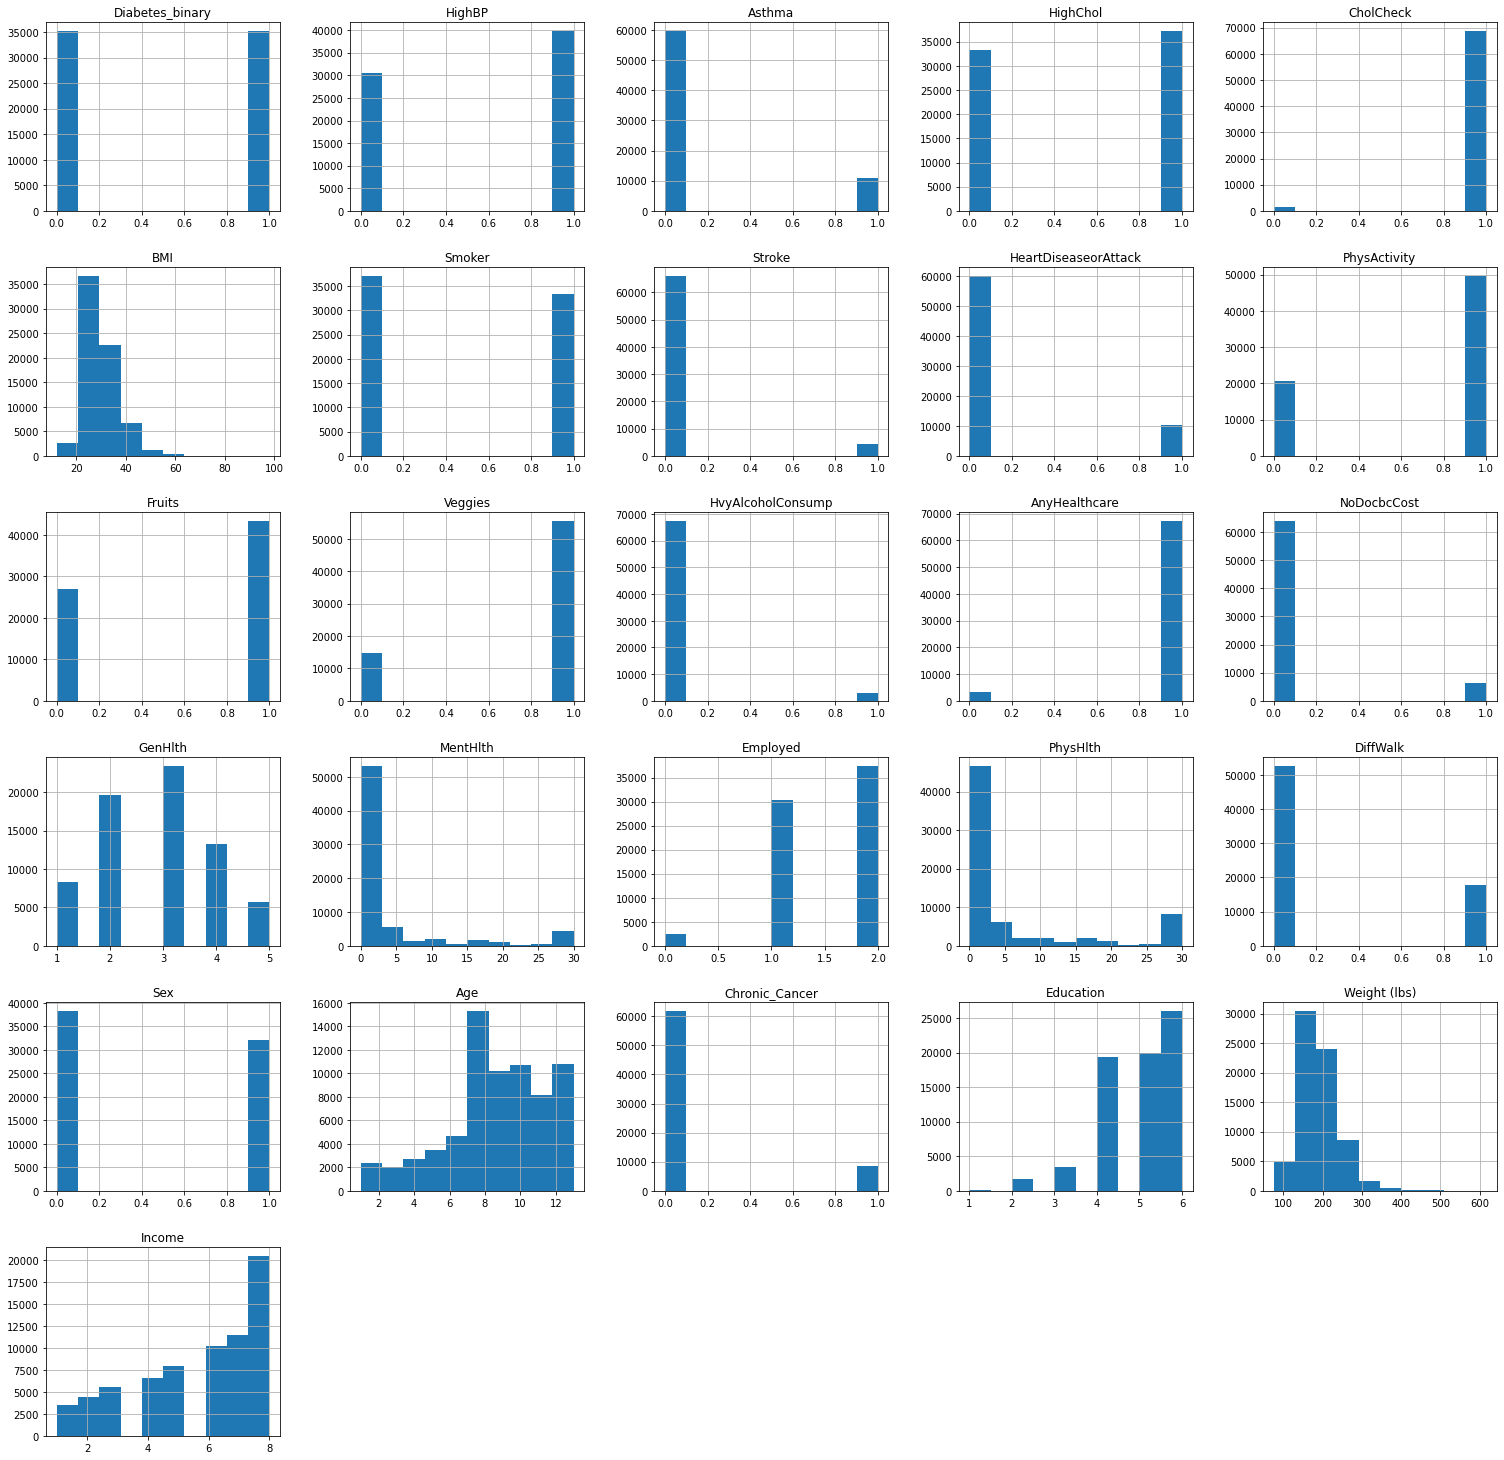

In [5]:
p = diab_df.hist(figsize = (26,26))

We can see a few interesting trends from the various histograms. First the diabetes versus non-diabetes is balanced as designed in the data cleaning process.

Second, High Blood pressure is also near balanced.

Weight is centered around near 200 points, which tracks on average.

There are more females than males in this study.

Higher incomes are mostly represented in the study. This could imply that the study is biased towards collecting data for those of a higher income. This would make sense since higher income individuals are more likely too have landlines. 

Similarly, variables that show co-morbities such as stroke, heart disease, and chronic cancer victims are not represented well in the data.


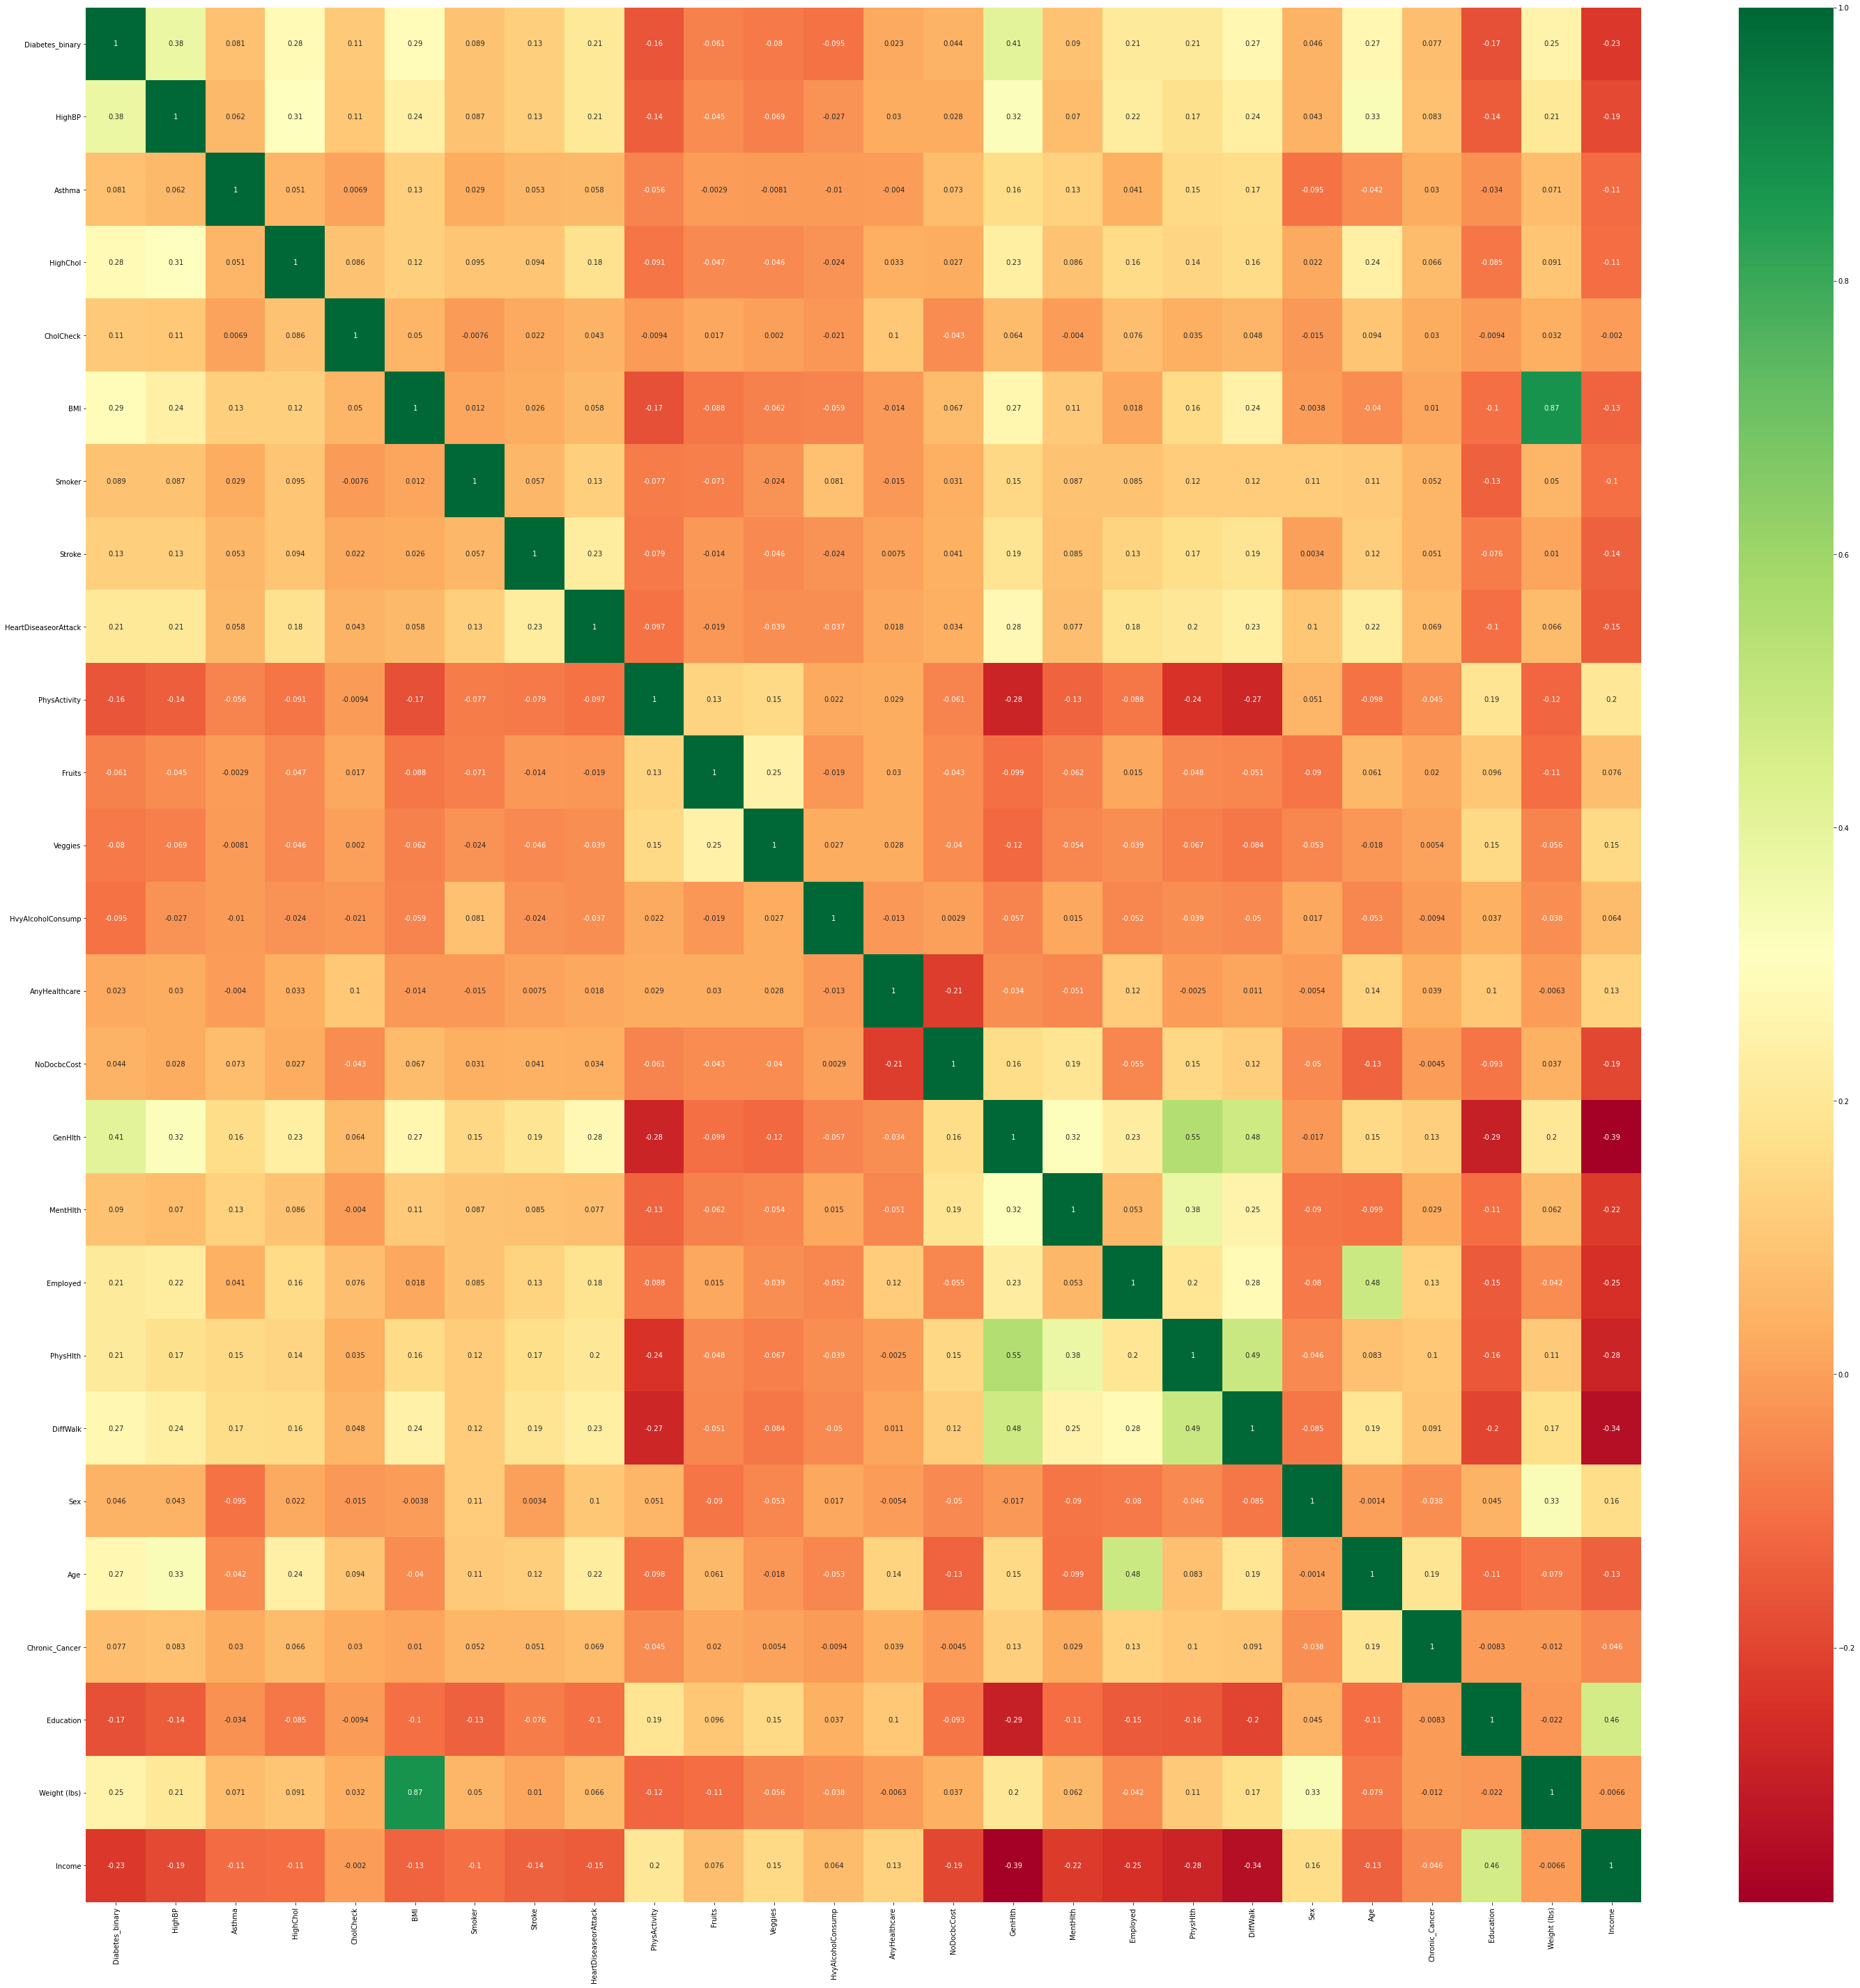

In [6]:
plt.figure(figsize=(50,50))
p = sns.heatmap(diab_df.corr(), annot=True,cmap ='RdYlGn')

The vast majority of variables are not correlated with one another. This makes this data set could for modeling and less likely for overfitting/multicolinearity.

However, there is one exception. That being BMI and Weight. Since BMI is calculated from Weight this is not suprising.

To reduce the possibility of overfitting, we will drop the weight column. We chose to drop weight instead of BMI because BMI is more correlated with diabetes than weight is (0.29 vs 0.25). Therefore, dropping BMI as a feature would reduce the accuracy of the model more than weight would.

This data-driven decisions tracks with intuition. BMI is a better metric of determining how unhealthy an individual is since it incorporates height. A 6 foot individual weighing 180 pounds would be considered healthy while a 5 foot individual would not of that weight.

In [7]:
# Drop Weight column

diab_df = diab_df.drop('Weight (lbs)',axis=1)

In [8]:
diab_df.columns

Index(['Diabetes_binary', 'HighBP', 'Asthma', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
       'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
       'GenHlth', 'MentHlth', 'Employed', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Chronic_Cancer', 'Education', 'Income'],
      dtype='object')

# Modeling

First we scaled the data using the standard scaler classifier. Then we performed a train-test split on our data. 80% of the data went into our training dataframe and 20% was in our testing set. We first evaluated our data through a logistic regression. Logistic regression will serve as our baseline model. We found that logistic regression had an accuracy of 75% and precision of 74%. The data did not seem over or underfit since the training accuracy was also 75%.

Then we ran the data through additional models such as Random Forest, XGBoost, Decision Tree Classifier, Support Vector Machines, GaussianNB, and KNeighbors. We found that most had an accuracy of near 75%. SVC had the highest accuracy by a margin, but took the longest to evaluate. As a result, we decided not to move forward with that model.

We decided to tune XGBoost more since it had the second highest accuracy and ran fairly quickly (6 seconds). We used a bayesian optimizer since literature indicated that it was more effective than grid or random searching. We found that tuning with this optimizer marginally improved the accuracy, but increased the time it took to train the model on the data.

Finally, we created a neural network since multiple articles indicated that it was the most accurate for this problem. We ended up implementing a 3 layer neural network with early stopping, but found it only marginally improved the accuracy over a tuned XGBoost and the baseline model.


Sub-sections include
* Scaled Data for Model
* Ran Baseline Model
* Ran Additional Models
* Tuned best performing model from 'Additional Models' section
* Created a neural network since literature implied it was the best performing model for this use-case

In [9]:
# Instantiate standard scaler

sc_X = StandardScaler()

In [10]:
# Target variable (y) is diabetes_binary since that is what we are predicting
# rest of dataframe features go into X

X = diab_df.loc[:,diab_df.columns != 'Diabetes_binary']
y = diab_df['Diabetes_binary']

In [11]:
# Apply scaler to feature data

X_scaled = sc_X.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled

,HighBP,Asthma,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,GenHlth,MentHlth,Employed,PhysHlth,DiffWalk,Sex,Age,Chronic_Cancer,Education,Income
0,-1.14055,-0.425492,-1.057809,0.156285,-1.379308,-0.948568,-0.257453,-0.417718,0.647659,-1.265253,...,-0.751084,-0.335240,-0.875038,-0.576901,-0.581953,-0.915502,-1.968617,-0.371877,1.045669,1.059132
1,-1.14055,2.350221,0.945350,0.156285,0.301592,1.054221,-0.257453,-0.417718,-1.544023,0.790355,...,0.147490,-0.458717,0.889861,-0.278505,1.718353,1.092297,1.545147,-0.371877,0.074280,-1.245449
2,0.87677,-0.425492,-1.057809,0.156285,2.822943,1.054221,-0.257453,-0.417718,0.647659,-1.265253,...,1.046064,3.245579,-0.875038,-0.477436,-0.581953,-0.915502,-0.914488,-0.371877,1.045669,-0.323616
3,0.87677,-0.425492,0.945350,0.156285,-0.398783,-0.948568,-0.257453,2.393962,0.647659,0.790355,...,0.147490,1.023001,0.889861,-0.377971,-0.581953,-0.915502,0.842394,-0.371877,-0.897110,-0.323616
4,0.87677,-0.425492,0.945350,0.156285,-2.219758,1.054221,-0.257453,-0.417718,-1.544023,-1.265253,...,1.944638,-0.458717,0.889861,2.407061,1.718353,1.092297,0.842394,-0.371877,-1.868499,-1.245449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70247,-1.14055,-0.425492,0.945350,0.156285,1.001967,-0.948568,-0.257453,-0.417718,-1.544023,-1.265253,...,1.046064,-0.458717,-0.875038,-0.576901,-0.581953,-0.915502,-0.914488,-0.371877,-0.897110,-2.167281
70248,-1.14055,-0.425492,0.945350,0.156285,-0.118633,1.054221,-0.257453,2.393962,-1.544023,0.790355,...,-0.751084,-0.458717,-0.875038,-0.576901,1.718353,1.092297,0.491018,-0.371877,-1.868499,0.137300
70249,0.87677,2.350221,0.945350,0.156285,-0.678933,-0.948568,-0.257453,2.393962,-1.544023,0.790355,...,1.944638,1.393431,0.889861,-0.576901,1.718353,-0.915502,1.545147,2.689061,1.045669,-0.784533
70250,0.87677,-0.425492,0.945350,0.156285,-1.659458,-0.948568,-0.257453,-0.417718,-1.544023,-1.265253,...,1.046064,-0.458717,0.889861,-0.576901,1.718353,-0.915502,0.842394,-0.371877,-2.839889,-0.784533


In [12]:
# Splitting the data between the training and testing set
# 80% of the data is in the training data frame and 20% is in the testing one.

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.20)

In [13]:
# Pickle data to run models in other notebooks

with open('Variables/X_train.pickle', 'wb') as xtr:
    pickle.dump(X_train,xtr)



In [14]:
#Store other variables

with open('Variables/X_test.pickle', 'wb') as xtst:
    pickle.dump(X_test,xtst)
    
with open('Variables/y_train.pickle', 'wb') as ytr:
    pickle.dump(y_train,ytr)
    
    
with open('Variables/y_test.pickle', 'wb') as ytst:
    pickle.dump(y_test,ytst)

## Baseline Model

Logistic regression will serve as our baseline model. We found that logistic regression had an accuracy of 75% and precision of 74%. The data did not seem over or underfit since the training accuracy was also 75%. We also reviewed the features the model deemed most importance and found that general health was the highest followed by age, BMI, and high blood pressure.

In [15]:
# Baseline Model is a logistic regression
# train the data

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)

LogisticRegression()

In [16]:
# get training accuracy to check for overfitting

lr_preds = lr_model.predict(X_train)

lr_train_acc = round(metrics.accuracy_score(y_train,lr_preds),3)

In [17]:
print('Training Accuracy score is ',lr_train_acc)

Training Accuracy score is  0.745


In [18]:
# Predictions from testing data set

y_pred = lr_model.predict(X_test)

In [19]:
# Get all metrics for data

lr_acc = metrics.accuracy_score(y_test, y_pred)
lr_rec = recall_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred)
lr_roc_auc = roc_auc_score(y_test, y_pred)
lr_F1 = f1_score(y_test,y_pred)

print('Accuracy: ',lr_acc)
print('Recall: ',lr_rec)
print('Precision', lr_prec)
print('ROC - AUC',lr_roc_auc)
print('F1 Score',lr_F1)

Accuracy:  0.7506939007899793
Recall:  0.7756822403200457
Precision 0.7374354794892692
ROC - AUC 0.7507878019524222
F1 Score 0.7560754822087599


Since the testing and training accuracy are close, it appears that we are not overfitting the data.

Let's take a look at the features this model prioritized.

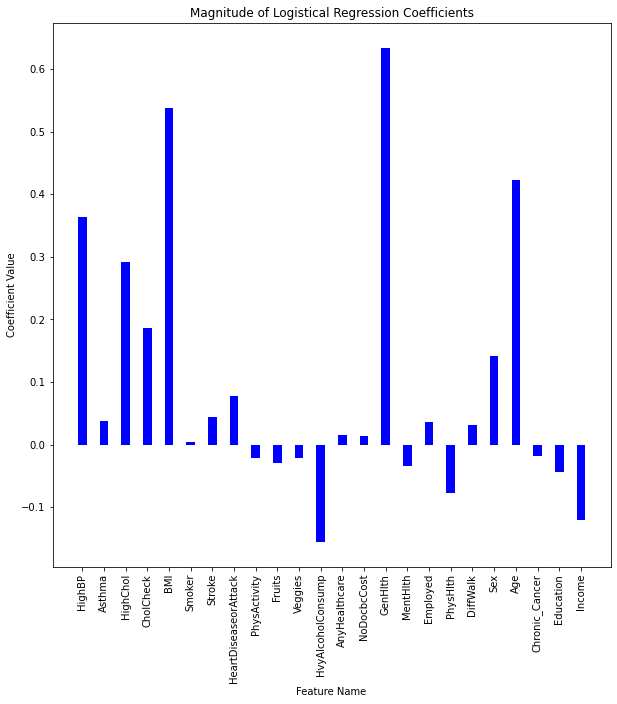

In [20]:
fig = plt.figure(figsize = (10, 10))

feature_name = X_train.columns
coef_val = lr_model.coef_[0]
 
# creating the bar plot
plt.bar(feature_name, coef_val, color ='blue', 
        width = 0.4)
 
plt.xlabel("Feature Name")
plt.ylabel("Coefficient Value")
plt.title("Magnitude of Logistical Regression Coefficients")
plt.xticks(rotation=90)
plt.show()

We can see that the feature given the most importance was GenHlth.

Other top features were High Blood Pressure, BMI, and Age.

Interestingly, heavy alcohol consumption did not positively affect diabetes correlation. Even though intuitively, one would think that more alcohol means more calories/sugar, which means higher likelyhood for diabetes.

In [21]:
# Get confusion matrix values on baseline model.

cm = confusion_matrix(y_test, y_pred)
lr_TN, lr_FP, lr_FN, lr_TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', lr_TP)
print('False Positive(FP) = ', lr_FP)
print('True Negative(TN)  = ', lr_TN)
print('False Negative(FN) = ', lr_FN)

True Positive(TP)  =  5429
False Positive(FP) =  1933
True Negative(TN)  =  5119
False Negative(FN) =  1570


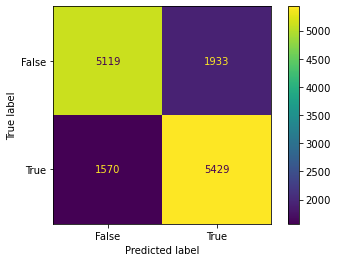

In [22]:
# Plot confusion matrix

cm_matrix = metrics.confusion_matrix(y_test,y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

The confusion matrix above identifies similar amounts of true positives and true negatives. In addition, it also identified a similar number of false positives and false negatives.

* True Positive(TP)  =  5320
* False Positive(FP) =  1982
* True Negative(TN)  =  5033
* False Negative(FN) =  1716


These numbers are not too bad for a baseline model. The training and testing accuracy were similar, 74% indicating that the model is not overfitting the data. Let's see if we can use other models to improve these metrics from a baseline of 74%.

## Additional Models

We ran additional models such as Random Forest, XGB, Deicison Tree Classier, GaussianNB, and KNeighbors. We reviewed ML metrics such as accuracy, precision, and ROC. In additon, we also reviewed the time it took the model to run. We found that most had an accuracy of near 75%. SVC had the highest accuracy by a margin, but took the longest to evaluate. As a result, we decided not to move forward with that model. We decided to tune XGBoost more since it had the second highest accuracy and ran fairly quickly (6 seconds).

In [23]:
# Models we want to test

model_arr = {}
model_arr['Logistical Regression'] = LogisticRegression()
model_arr['Random Forest'] = RandomForestClassifier()
model_arr['Decision Tree Classifer'] = DecisionTreeClassifier()
model_arr['XGB Classifier'] = XGBClassifier(gamma=0)
model_arr['SVC'] = SVC()
model_arr['GaussianNB'] = GaussianNB()
model_arr['KNeighbors']  = KNeighborsClassifier()

In [24]:
# loop over each classifier to evaluate poerformance

train_acc, test_acc, rec, prec, F1, Roc_Auc,trained_model,run_time = {}, {}, {}, {}, {}, {},{},{}

for model_name in model_arr.keys():
    
    model = model_arr[model_name]
    
    start = dt.now()
    
    # Fit the classifier
    trained_model[model_name] = model.fit(X_train, y_train)   #Store the trained model for further analysis
    
    #Find training accuracy
    
    y_train_pred = model.predict(X_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    running_secs = (dt.now() - start).seconds
    
    # Calculate metrics
    train_acc[model_name] = accuracy_score(y_train,y_train_pred)
    test_acc[model_name] = accuracy_score(y_test, y_pred)
    rec[model_name] = recall_score(y_test, y_pred)
    prec[model_name] = precision_score(y_test, y_pred)
    F1[model_name] = f1_score(y_test,y_pred)
    Roc_Auc[model_name] = roc_auc_score(y_test,y_pred)
    run_time[model_name] = running_secs

In [25]:
measures = pd.DataFrame(index=model_arr.keys(), columns=['Training Accuracy','Testing Accuracy','Recall','Precision','F1 Score','Roc-AUC Score','Runtime (s)'])
measures['Training Accuracy'] = train_acc.values()
measures['Testing Accuracy'] = test_acc.values()
measures['Recall'] = rec.values()
measures['Precision'] = prec.values()
measures['F1 Score'] = F1.values()
measures['Roc-AUC Score'] = Roc_Auc.values()
measures['Runtime (s)'] = run_time.values()
measures

,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score,Roc-AUC Score,Runtime (s)
Logistical Regression,0.744880,0.750694,0.775682,0.737435,0.756075,0.750788,0
Random Forest,0.997135,0.741442,0.784826,0.720866,0.751488,0.741605,9
Decision Tree Classifer,0.997153,0.659526,0.649807,0.660950,0.655331,0.659489,0
XGB Classifier,0.791605,0.749057,0.793542,0.727439,0.759054,0.749224,6
SVC,0.768296,0.751619,0.807830,0.724965,0.764157,0.751830,4194
GaussianNB,0.714542,0.720518,0.709673,0.723841,0.716687,0.720477,0
KNeighbors,0.794932,0.706213,0.731533,0.694803,0.712695,0.706308,309


The dispararity between the training and testing accuracy above for Random Forest and Decision Tree Classifier indicates that those models are highly overfit. Especially, the Decision Tree Classifier which had the lowest testing accuracy but a near 100% training accuracy.

The testing accuracies of the rest of the models were similar. SVC and XGB have the highest accuracies and have very close metrics to one another.

The only differences is that XGB has a marginally higher precision and SVC has a higher recall by 1% and a ROC-AUC score and accuracy score. Based on these metrics alone, it would make sense to chose SVC over XGB. 

However, XGB runs significantly faster than SVC. In fact, XGB ran ~80 times faster than SVC. Note: Times may vary depending on machine. Since its significantly easier to use.

Ultimately, all of these models fall short of logistical's regressions accuracy to runtime ratio. Of all the models that ran in 0 seconds, logistical regression had the highest accuracy/precision.

That said, XGB has the potential to improve on these numbers through hyper-parameter tuning. We will be using this model for further analysis to try on improving on these results.

In [26]:
# Store model to xgb variable for easier use with calculations below

xgb = trained_model['XGB Classifier']

In [27]:
# Create a confusion matrix to visualize results

y_pred_xgb = xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred_xgb)
xgb_TN, xgb_FP, xgb_FN, xgb_TP = confusion_matrix(y_test, y_pred_xgb).ravel()

print('True Positive(TP)  = ', xgb_TP)
print('False Positive(FP) = ', xgb_FP)
print('True Negative(TN)  = ', xgb_TN)
print('False Negative(FN) = ', xgb_FN)

True Positive(TP)  =  5554
False Positive(FP) =  2081
True Negative(TN)  =  4971
False Negative(FN) =  1445


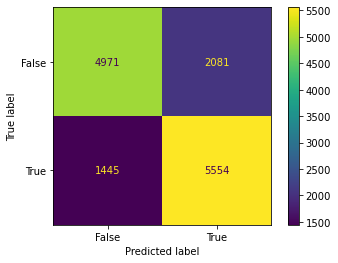

In [28]:
# Plot Results

xgb_cm_matrix = confusion_matrix(y_test,y_pred_xgb)

xgb_cm_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_matrix, display_labels = [False, True])

xgb_cm_display.plot()
plt.show()

The confusion matrix above shows a high number of true positives/true negatives compared to the false positives/negatives. Let's see how many more correct prediction it made compared to the baseline model.


In [29]:
# Print TP, TN, FP, and FN numbers

print('True Positive(TP)  = ', xgb_TP)
print('False Positive(FP) = ', xgb_FP)
print('True Negative(TN)  = ', xgb_TN)
print('False Negative(FN) = ', xgb_FN)

True Positive(TP)  =  5554
False Positive(FP) =  2081
True Negative(TN)  =  4971
False Negative(FN) =  1445


In [30]:
# Find the difference in correct predictions made between the xgboost Model and the Logistical Regression
# Correct Predictions are defined as the number of TP + TN

lr_corr_pred = lr_TP + lr_TN # Correct number of predictions made by baseline logistic regression model
xgb_corr_pred = xgb_TP + xgb_TN  # Correct number of predictions made by xgboost model

diff_preds_1 = abs(lr_corr_pred - xgb_corr_pred)

print("The xgboost model made",diff_preds_1,"more correct predictions than the baseline model.")

The xgboost model made 23 more correct predictions than the baseline model.


Let's take a look at what features XGB deemed important.

<AxesSubplot:>

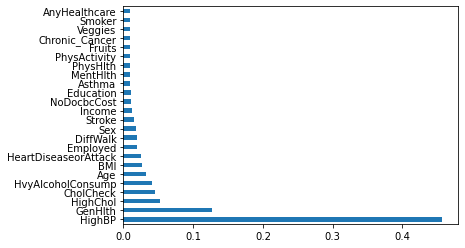

In [31]:
# Visualize Feature importance

pd.Series(xgb.feature_importances_, index=X_scaled.columns).sort_values(ascending=False).plot(kind='barh')

Interestingly, the model put the highest weight on blood pressure by a significant margin. Almost 4 times higher than the next parameter of general health. This find tracks well with medical knowledge that high blood pressure and diabetes often are caused by unhealthy diet/health maintenance.

## Hyper Parameter Tuning

Now that we have picked a model to further investigate, let's see if we can improve our accuracy through hyper parameter tuning. There are different methods for hyper parameter tuning such as grid searching and random search, but here we will use bayesian optimization. From research, we determined that this method is generally more successful than the others.

Due too time and resources constraints we will use this method instead of trying several and comparing the results.

Source: *Hyperparameter Optimization for Machine Learning Models Based on Bayesian Optimization*, Wu et. al. <a href="https://www.sciencedirect.com/science/article/pii/S1674862X19300047">link</a>


In [32]:
# Needed to install this via !pip

from bayes_opt import BayesianOptimization

In [33]:
from sklearn.model_selection import cross_val_score

In [34]:
from hyperopt import fmin, tpe, hp

In [35]:
#Function that takes in parameters for xgboost and returns the highest roc-auc score from the cross validations

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        gamma):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma)
    return np.mean(cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc'))



In [36]:
# Parameters for xgboost model. Start with arbirtrary parameter values

pbounds = {
    'learning_rate': (0.01, 1.0),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'subsample': (1.0, 1.0), 
    'gamma': (0, 5)}


In [37]:
#Instantiate the Optimizer

optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds
)

In [38]:
# First try with 3 iterations and two initial points.

optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8242    | 3.577     | 0.07071   | 9.735     | 245.3     | 1.0       |
| 2         | 0.8284    | 2.232     | 0.1906    | 4.772     | 836.6     | 1.0       |
| 3         | 0.8268    | 2.036     | 0.225     | 5.656     | 835.6     | 1.0       |
| 4         | 0.8288    | 4.094     | 0.114     | 4.502     | 836.7     | 1.0       |
| 5         | 0.8291    | 1.773     | 0.1077    | 3.251     | 839.6     | 1.0       |


In [39]:
optimizer.max

{'target': 0.8290578541556393,
 'params': {'gamma': 1.7730705215664444,
  'learning_rate': 0.10771521447372878,
  'max_depth': 3.25084787868769,
  'n_estimators': 839.600614942945,
  'subsample': 1.0}}

In [40]:
#parameters are in the 'params' keys

xgb_best_params = optimizer.max['params']

xgb_best_params

{'gamma': 1.7730705215664444,
 'learning_rate': 0.10771521447372878,
 'max_depth': 3.25084787868769,
 'n_estimators': 839.600614942945,
 'subsample': 1.0}

In [41]:
# Create new classier with the best params

gamma = xgb_best_params['gamma']
learning_rate = xgb_best_params['learning_rate']
max_depth = int(round(xgb_best_params['max_depth'])) # Needs to be an int not a float
n_estimators = int(round(xgb_best_params['n_estimators'])) # Needs to be an int not a float


xgb_tuned = XGBClassifier(gamma = gamma,learning_rate=learning_rate,max_depth=max_depth,n_estimators=n_estimators,subsample=1.0)

In [42]:
# Fit tuned model on training data

start = dt.now()

xgb_tuned.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.7730705215664444,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.10771521447372878, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=840, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
# Make predictions. Do the same for training data to determine if there is overfitting

y_pred_tuned_train = xgb_tuned.predict(X_train)
y_pred_tuned  = xgb_tuned.predict(X_test)

running_secs_xgb = (dt.now() - start).seconds

In [44]:
# Return metrics on ML scores

xgb_tnd_trn_acc = accuracy_score(y_train,y_pred_tuned_train)
xgb_tnd_tst_acc = accuracy_score(y_test, y_pred_tuned)
xgb_tnd_rec = recall_score(y_test, y_pred_tuned)
xgb_tnd_rec_prec = precision_score(y_test, y_pred_tuned)
xgb_tnd_rec_roc_auc = roc_auc_score(y_test, y_pred_tuned)
xgb_tnd_rec_F1 = f1_score(y_test,y_pred_tuned)

print('Training Accuracy: ',xgb_tnd_trn_acc)
print('Testing Accuracy: ',xgb_tnd_tst_acc)
print('Recall: ',xgb_tnd_rec)
print('Precision', xgb_tnd_rec_prec)
print('ROC - AUC',xgb_tnd_rec_roc_auc)
print('F1 Score',xgb_tnd_rec_F1)

Training Accuracy:  0.7577267308410882
Testing Accuracy:  0.7524731335847983
Recall:  0.8015430775825118
Precision 0.7286660605273412
ROC - AUC 0.7526575285813863
F1 Score 0.7633691658729078


It appears the parameters did not change the results significantly. For better visualization let's use a confusion matrix.

In [45]:
# Get confusion matrix of first tuning

cm_xgb_tnd = confusion_matrix(y_test, y_pred_tuned)
TN_xgb_tnd, FP_xgb_tnd, FN_xgb_tnd, TP_xgb_tnd = confusion_matrix(y_test, y_pred_tuned).ravel()

print('True Positive(TP)  = ', TP_xgb_tnd)
print('False Positive(FP) = ', FP_xgb_tnd)
print('True Negative(TN)  = ', TN_xgb_tnd)
print('False Negative(FN) = ', FN_xgb_tnd)

True Positive(TP)  =  5610
False Positive(FP) =  2089
True Negative(TN)  =  4963
False Negative(FN) =  1389


In [46]:
# Difference between first tuning iteration and baseline model

lr_TP + lr_TN - TP_xgb_tnd - TN_xgb_tnd

-25

This tuning actually reduced the number of correct predictions the model makes.

In [47]:
# Add these values to our model dictionary
# Since pandas does not allow you to add rows without removing the indices correspond to the models,
# we need to recreate the table again

model_name = 'XGB Tuned 1'
model_arr['XGB Tuned 1'] = xgb_tuned

train_acc[model_name] = xgb_tnd_trn_acc
test_acc[model_name] = xgb_tnd_tst_acc
rec[model_name] = xgb_tnd_rec
prec[model_name] = xgb_tnd_rec_prec
F1[model_name] = xgb_tnd_rec_F1
Roc_Auc[model_name] = xgb_tnd_rec_roc_auc
run_time[model_name] = running_secs_xgb

In [48]:
# Add first tuning to table with model metrics

measures = pd.DataFrame(index=model_arr.keys(), columns=['Training Accuracy','Testing Accuracy','Recall','Precision','F1 Score','Roc-AUC Score','Runtime (s)'])
measures['Training Accuracy'] = train_acc.values()
measures['Testing Accuracy'] = test_acc.values()
measures['Recall'] = rec.values()
measures['Precision'] = prec.values()
measures['F1 Score'] = F1.values()
measures['Roc-AUC Score'] = Roc_Auc.values()
measures['Runtime (s)'] = run_time.values()
measures

,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score,Roc-AUC Score,Runtime (s)
Logistical Regression,0.744880,0.750694,0.775682,0.737435,0.756075,0.750788,0
Random Forest,0.997135,0.741442,0.784826,0.720866,0.751488,0.741605,9
Decision Tree Classifer,0.997153,0.659526,0.649807,0.660950,0.655331,0.659489,0
XGB Classifier,0.791605,0.749057,0.793542,0.727439,0.759054,0.749224,6
SVC,0.768296,0.751619,0.807830,0.724965,0.764157,0.751830,4194
GaussianNB,0.714542,0.720518,0.709673,0.723841,0.716687,0.720477,0
KNeighbors,0.794932,0.706213,0.731533,0.694803,0.712695,0.706308,309
XGB Tuned 1,0.757727,0.752473,0.801543,0.728666,0.763369,0.752658,30


Let's see if we can further improve them by increasing the bounds and also by increasing the number of iterations the optimizer runs over.

In [49]:
# Increase space we search over for tuned parameters

pbounds2 = {
    'learning_rate': (0.01, 0.6),
    'n_estimators': (100, 300),
    'max_depth': (3,7),
    'subsample': (1.0, 1.0),
    'gamma': (5, 20)}


optimizer2 = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds
)

In [50]:
# Increased init_points and n_iter by 1 from previous tuning

optimizer2.maximize(
    init_points=4,
    n_iter=5,
)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8066    | 2.236     | 0.4016    | 9.652     | 877.6     | 1.0       |
| 2         | 0.8288    | 4.287     | 0.09599   | 3.467     | 365.4     | 1.0       |
| 3         | 0.8214    | 1.987     | 0.5107    | 5.108     | 596.7     | 1.0       |
| 4         | 0.8282    | 4.015     | 0.2006    | 4.876     | 388.4     | 1.0       |
| 5         | 0.8284    | 3.819     | 0.2693    | 3.795     | 389.4     | 1.0       |
| 6         | 0.8241    | 0.8798    | 0.696     | 3.579     | 247.1     | 1.0       |
| 7         | 0.8174    | 4.294     | 0.6381    | 6.379     | 100.1     | 1.0       |
| 8         | 0.8287    | 2.549     | 0.1412    | 3.142     | 478.8     | 1.0       |
| 9         | 0.8265    | 1.456     | 0.4211    | 3.118     | 711.0     | 1.0       |


In [51]:
# Store best parameters in xgb_best_params2

xgb_best_params2 = optimizer2.max['params']
xgb_best_params2

{'gamma': 4.28706204168959,
 'learning_rate': 0.0959934394844797,
 'max_depth': 3.4669076899283535,
 'n_estimators': 365.40273318207534,
 'subsample': 1.0}

In [52]:
# Create new classier with the best params
gamma = xgb_best_params2['gamma']
learning_rate = xgb_best_params2['learning_rate']
max_depth = int(round(xgb_best_params2['max_depth'])) # Needs to be an int not a float
n_estimators = int(round(xgb_best_params2['n_estimators'])) # Needs to be an int not a float


xgb_tuned_2 = XGBClassifier(gamma = gamma,learning_rate=learning_rate,max_depth=max_depth,n_estimators=n_estimators,subsample=1.0)

In [53]:
# Start timer time it takes to train and predict

start = dt.now()

xgb_tuned_2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=4.28706204168959,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0959934394844797, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=365, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
# Make predictions and finish recording time it takes to train and predict 

y_pred_tuned_2_train = xgb_tuned_2.predict(X_train)
y_pred_tuned_2  = xgb_tuned_2.predict(X_test)

running_secs_xgb_2 = (dt.now() - start).seconds

In [55]:
# Get ML metrics for second round of tuning

xgb_tnd_2_trn_acc = accuracy_score(y_train,y_pred_tuned_2_train)
xgb_tnd_2_tst_acc = accuracy_score(y_test, y_pred_tuned_2)
xgb_tnd_2_rec = recall_score(y_test, y_pred_tuned_2)
xgb_tnd_2_rec_prec = precision_score(y_test, y_pred_tuned_2)
xgb_tnd_2_rec_roc_auc = roc_auc_score(y_test, y_pred_tuned_2)
xgb_tnd_2_rec_F1 = f1_score(y_test,y_pred_tuned_2)

print('Training Accuracy: ',xgb_tnd_2_trn_acc)
print('Testing Accuracy: ',xgb_tnd_2_tst_acc)
print('Recall: ',xgb_tnd_2_rec)
print('Precision', xgb_tnd_2_rec_prec)
print('ROC - AUC',xgb_tnd_2_rec_roc_auc)
print('F1 Score',xgb_tnd_2_rec_F1)

Training Accuracy:  0.7557516770164232
Testing Accuracy:  0.7519037790904562
Recall:  0.8012573224746392
Precision 0.728028041022978
ROC - AUC 0.7520892397965935
F1 Score 0.7628894028023399


In [56]:
# Add these values to our model dictionary
# Since pandas does not allow you to add rows without removing the indices correspond to the models,
# we need to recreate the table again

model_name = 'XGB Tuned 2'
model_arr['XGB Tuned 2'] = xgb_tuned_2

train_acc[model_name] = xgb_tnd_2_trn_acc
test_acc[model_name] = xgb_tnd_2_tst_acc
rec[model_name] = xgb_tnd_2_rec
prec[model_name] = xgb_tnd_2_rec_prec
F1[model_name] = xgb_tnd_2_rec_F1
Roc_Auc[model_name] = xgb_tnd_2_rec_roc_auc
run_time[model_name] = running_secs_xgb_2

In [57]:
# Add second tuned model to table.

measures = pd.DataFrame(index=model_arr.keys(), columns=['Training Accuracy','Testing Accuracy','Recall','Precision','F1 Score','Roc-AUC Score','Runtime (s)'])
measures['Training Accuracy'] = train_acc.values()
measures['Testing Accuracy'] = test_acc.values()
measures['Recall'] = rec.values()
measures['Precision'] = prec.values()
measures['F1 Score'] = F1.values()
measures['Roc-AUC Score'] = Roc_Auc.values()
measures['Runtime (s)'] = run_time.values()
measures

,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score,Roc-AUC Score,Runtime (s)
Logistical Regression,0.744880,0.750694,0.775682,0.737435,0.756075,0.750788,0
Random Forest,0.997135,0.741442,0.784826,0.720866,0.751488,0.741605,9
Decision Tree Classifer,0.997153,0.659526,0.649807,0.660950,0.655331,0.659489,0
XGB Classifier,0.791605,0.749057,0.793542,0.727439,0.759054,0.749224,6
SVC,0.768296,0.751619,0.807830,0.724965,0.764157,0.751830,4194
GaussianNB,0.714542,0.720518,0.709673,0.723841,0.716687,0.720477,0
KNeighbors,0.794932,0.706213,0.731533,0.694803,0.712695,0.706308,309
XGB Tuned 1,0.757727,0.752473,0.801543,0.728666,0.763369,0.752658,30
XGB Tuned 2,0.755752,0.751904,0.801257,0.728028,0.762889,0.752089,12


These numbers seem slightly better than the initial Xgboost model as well as the baseline. Given the magnitude of data we are working over, over 10,000 records, the gains are marginal at best.

However, interestingly it took less time for the second tuned model to evaluate. The second tuning showed good improvements.

With more computation resources, it would be interesting to see how much higher we can increase the accuracy of the model.

In [58]:
# Get confusion matrix values for second tuned model

cm_xgb_tnd = confusion_matrix(y_test, y_pred_tuned_2)
TN_xgb_tnd2, FP_xgb_tnd2, FN_xgb_tnd2, TP_xgb_tnd2 = confusion_matrix(y_test, y_pred_tuned_2).ravel()

print('True Positive(TP)  = ', TP_xgb_tnd2)
print('False Positive(FP) = ', FP_xgb_tnd2)
print('True Negative(TN)  = ', TN_xgb_tnd2)
print('False Negative(FN) = ', FN_xgb_tnd2)

True Positive(TP)  =  5608
False Positive(FP) =  2095
True Negative(TN)  =  4957
False Negative(FN) =  1391


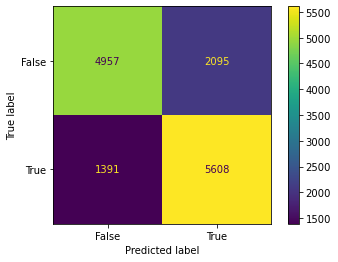

In [59]:
# Plot confusion matrix

cm_xgb_tnd = confusion_matrix(y_test,y_pred_tuned_2)

cm_xgb_tnd = ConfusionMatrixDisplay(confusion_matrix = cm_xgb_tnd, display_labels = [False, True])

cm_xgb_tnd.plot()
plt.show()

The tuned model has performed slightly better than the baseline and initial XGBoost model. Since the percentages are small, let's see how many correct predictions this translates too.

In [60]:
# Find the difference in correct predictions made between the tuned XGBoost Model and the un-tuned model and baseline
# Correct Predictions are defined as the number of TP + TN

lr_corr_pred = lr_TP + lr_TN # Correct number of predictions made by baseline logistic regression model
xgb_corr_pred = xgb_TP + xgb_TN  # Correct number of predictions made by XGBoost model

xgb_tnd_corr_pred = TP_xgb_tnd + TN_xgb_tnd

diff_preds_1 = xgb_corr_pred - lr_corr_pred
diff_preds_2 = xgb_tnd_corr_pred - xgb_corr_pred
diff_preds_3 = xgb_tnd_corr_pred - lr_corr_pred


print("The initial XGBoost model made",diff_preds_1,"more correct predictions than the baseline model.")
print("The tuned XGBoost model made",diff_preds_2,"more correct predictions than the initial XGBoost model.")
print("The tuned XGBoost model made",diff_preds_3,"more correct predictions than the baseline model.")



The initial XGBoost model made -23 more correct predictions than the baseline model.
The tuned XGBoost model made 48 more correct predictions than the initial XGBoost model.
The tuned XGBoost model made 25 more correct predictions than the baseline model.


Through our iterative modeling process we are increasing the accuracy of our model. However, these increases are marginal at best over a dataset that has tens of thousands of values.

It's unclear if the time and effort spent on tuning the model is worth the gain in accuracy.

<AxesSubplot:>

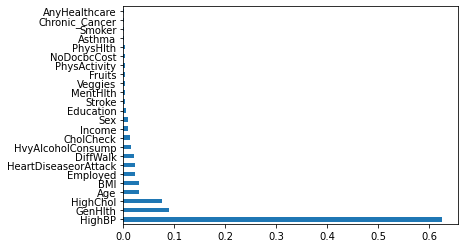

In [61]:
# Plot top features prioritized by tuned XGBoost model

pd.Series(xgb_tuned_2.feature_importances_, index=X_scaled.columns).sort_values(ascending=False).plot(kind='barh')

There does not seem to be a huge difference in the features. Though the coefficient for HighBP increased and the rest decreased.

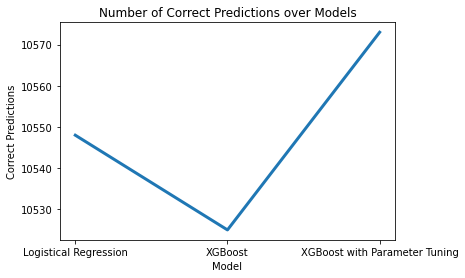

In [62]:
# Plot number of correct predictions over baseline, XGB, and XGB tuned model.

x_axis = ["Logistical Regression", "XGBoost", "XGBoost with Parameter Tuning"]
y_axis = [lr_corr_pred, xgb_corr_pred, xgb_tnd_corr_pred]

plt.plot(x_axis,y_axis,linewidth = 3)
plt.xlabel('Model')
plt.ylabel('Correct Predictions')
plt.title('Number of Correct Predictions over Models')

# Show the plot
plt.show()

## Using Neural Network Models on the Data

In addition to our own iterative modeling, we wanted to research the techniques experts were finding to be the most accurate in predicting diabetes.

We found several articles that found neural networks to provide the best model including one that used a dataset from a previous BRFSS dataset in a previous year.

The following sources evaluated the implementing different machine learning models on diabetes data. They concluded that neural networks were the best model when evaluating based on accuracy.

* *Building Risk Prediction Models for Type 2 Diabetes Using Machine Learning Techniques*, Xie et. al. <a href="https://www.cdc.gov/pcd/issues/2019/19_0109.htm">link</a>
 * This article used the 2014 data from the survey to create these models.
* *Cardiovascular complications in a diabetes prediction model using machine learning: a systematic review*, Kee et. al. <a href="https://link.springer.com/article/10.1186/s12933-023-01741-7">link</a>

We created our own neural network based on the data. Due to the size and amount of text generated by neural networks, we ran them on a different notebook. We saved the best model and loaded it here to create the confusion matrix, graphs, etc. 

The analysis and notebook containing the optimization of the neural network is <a href="notebooks/Neural_Network_Modeling.ipynb">here</a>

Only the architecture for the final model was included in the notebook.

The neural networks architecture is:

Neural
* 3 dense layers
 * 40 neurons in the first layer
 * 20 neurons in the second
 * 10 neurons in the third
* relu activation
* Use sigmoid curve
* Early Stopping

In [63]:
# Import keras and tensor flow for creating a neural network

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [64]:
# Uncomment if not running from scratch.

#nn_model = keras.models.load_model('Neural_Network')

In [65]:
# Instantiate the model

nn_model = Sequential()
num_features = X_train.shape[1]

In [66]:
# 1st layer: input_dim=8, 40 nodes, RELU
nn_model.add(Dense(40, input_dim=num_features, activation='relu'))
# 2nd layer: 20 nodes, RELU
nn_model.add(Dense(20, activation='relu'))
# 3rd layer: 
nn_model.add(Dense(10, activation='relu'))

# output layer: dim=1, activation sigmoid
nn_model.add(Dense(1, activation='sigmoid' ))

#  early stopping - monitor for validation loss. Wait for 5 epochs if loss increases. Allow for 1% error
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5,min_delta=1),
                   ModelCheckpoint(filepath='Neural_Network', monitor='val_loss',
                                  save_best_only=True)]

# Compile the model
nn_model.compile(loss='binary_crossentropy',   # since we are predicting 0/1
             optimizer='adam',
             metrics=['accuracy'])

In [67]:
# Fit model store in history variable

history = nn_model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=16,
                       callbacks=es)

Epoch 1/30
3513/3513 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.7418WARNING:tensorflow:From /Users/dhruvragunathan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Neural_Network/assets
3513/3513 [==============================] - 7s 2ms/step - loss: 0.5175 - accuracy: 0.7418 - val_loss: 0.5068 - val_accuracy: 0.7499
Epoch 2/30
3513/3513 [==============================] - 6s 2ms/step - loss: 0.5057 - accuracy: 0.7508 - val_loss: 0.5025 - val_accuracy: 0.7520
Epoch 3/30
3513/3513 [==============================] - 

In [68]:
# Predict on training data
# The data of y_preds_nn is float not binary 0/1 so we cannot compare it to y_test in current state

y_pred_nn = nn_model.predict(X_test)

y_pred_nn  

array([[0.5238265 ],
       [0.07140973],
       [0.67378545],
       ...,
       [0.6771128 ],
       [0.26969093],
       [0.6419188 ]], dtype=float32)

In [69]:
# We will round y_preds_nn to 0 or 1 depending on if it's above or below 0.5

y_pred_nn_rnd = np.around(y_pred_nn,0)

y_pred_nn_rnd

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [70]:
# Calculate metrics below

nn_trn_acc = 0.7578 # Pulled from neural network notebook
nn_tst_acc = accuracy_score(y_test, y_pred_nn_rnd)
nn_rec = recall_score(y_test, y_pred_nn_rnd)
nn_rec_prec = precision_score(y_test, y_pred_nn_rnd)
nn_rec_roc_auc = roc_auc_score(y_test, y_pred_nn_rnd)
nn_rec_F1 = f1_score(y_test,y_pred_nn_rnd)

print('Training Accuracy: ',nn_trn_acc)
print('Testing Accuracy: ',nn_tst_acc)
print('Recall: ',nn_rec)
print('Precision', nn_rec_prec)
print('ROC - AUC',nn_rec_roc_auc)
print('F1 Score',nn_rec_F1)

Training Accuracy:  0.7578
Testing Accuracy:  0.7538253505088606
Recall:  0.8136876696670953
Precision 0.7254777070063694
ROC - AUC 0.7540503010842567
F1 Score 0.7670550205401038


In [71]:
# Add these values to our model dictionary
# Since pandas does not allow you to add rows without removing the indices correspond to the models,
# we need to recreate the table again

model_name = 'Neural Network'
model_arr[model_name] = nn_model

train_acc[model_name] = nn_trn_acc
test_acc[model_name] = nn_tst_acc
rec[model_name] = nn_rec
prec[model_name] = nn_rec_prec
F1[model_name] = nn_rec_F1
Roc_Auc[model_name] = nn_rec_roc_auc
run_time[model_name] = 48 # Pulled from neural network notebook. This number is from the early stopping model.

In [72]:
# Add neural network to model data table

measures = pd.DataFrame(index=model_arr.keys(), columns=['Training Accuracy','Testing Accuracy','Recall','Precision','F1 Score','Roc-AUC Score','Runtime (s)'])
measures['Training Accuracy'] = train_acc.values()
measures['Testing Accuracy'] = test_acc.values()
measures['Recall'] = rec.values()
measures['Precision'] = prec.values()
measures['F1 Score'] = F1.values()
measures['Roc-AUC Score'] = Roc_Auc.values()
measures['Runtime (s)'] = run_time.values()
measures

,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score,Roc-AUC Score,Runtime (s)
Logistical Regression,0.744880,0.750694,0.775682,0.737435,0.756075,0.750788,0
Random Forest,0.997135,0.741442,0.784826,0.720866,0.751488,0.741605,9
Decision Tree Classifer,0.997153,0.659526,0.649807,0.660950,0.655331,0.659489,0
XGB Classifier,0.791605,0.749057,0.793542,0.727439,0.759054,0.749224,6
SVC,0.768296,0.751619,0.807830,0.724965,0.764157,0.751830,4194
GaussianNB,0.714542,0.720518,0.709673,0.723841,0.716687,0.720477,0
KNeighbors,0.794932,0.706213,0.731533,0.694803,0.712695,0.706308,309
XGB Tuned 1,0.757727,0.752473,0.801543,0.728666,0.763369,0.752658,30
XGB Tuned 2,0.755752,0.751904,0.801257,0.728028,0.762889,0.752089,12
Neural Network,0.757800,0.753825,0.813688,0.725478,0.767055,0.754050,48


In [73]:
# Get confusion matrix values

TN_nn, FP_nn, FN_nn, TP_nn = confusion_matrix(y_test, y_pred_nn_rnd).ravel()

print('True Positive(TP)  = ', TP_nn)
print('False Positive(FP) = ', FP_nn)
print('True Negative(TN)  = ', TN_nn)
print('False Negative(FN) = ', FN_nn)

True Positive(TP)  =  5695
False Positive(FP) =  2155
True Negative(TN)  =  4897
False Negative(FN) =  1304


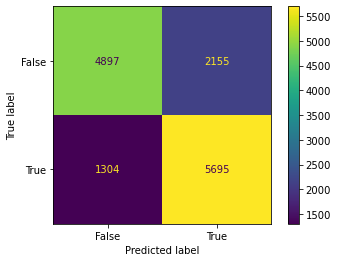

In [74]:
# Plot confusion matrix for NN

cm_nn = confusion_matrix(y_test,y_pred_nn_rnd)

cm_nn = ConfusionMatrixDisplay(confusion_matrix = cm_nn, display_labels = [False, True])

cm_nn.plot()
plt.show()

The neural network identified slightly more true positives and true negatives.

In [75]:
# Find the difference in correct predictions between all models
# Correct Predictions are defined as the number of TP + TN

lr_corr_pred = lr_TP + lr_TN # Correct number of predictions made by baseline logistic regression model
xgb_corr_pred = xgb_TP + xgb_TN  # Correct number of predictions made by XGBoost model
xgb_tnd_corr_pred = TP_xgb_tnd + TN_xgb_tnd # Correct number of predictions made by XGBoost tuned model
nn_corr_pred = TP_nn + TN_nn # Correct number of predictions made by neural network

diff_preds_1 = abs(xgb_corr_pred - lr_corr_pred)
diff_preds_2 = abs(xgb_tnd_corr_pred - xgb_corr_pred)
diff_preds_3 = abs(xgb_tnd_corr_pred - lr_corr_pred)
diff_preds_4 = abs(nn_corr_pred - xgb_tnd_corr_pred)


print("The initial XGBoost model made",diff_preds_1,"more correct predictions than the baseline model.")
print("The tuned XGBoost model made",diff_preds_2,"more correct predictions than the initial XGBoost model.")
print("The tuned XGBoost model made",diff_preds_3,"more correct predictions than the baseline model.")
print("The neural network made",diff_preds_4,"more correct predictions than the tuned XGBoost model.")

The initial XGBoost model made 23 more correct predictions than the baseline model.
The tuned XGBoost model made 48 more correct predictions than the initial XGBoost model.
The tuned XGBoost model made 25 more correct predictions than the baseline model.
The neural network made 19 more correct predictions than the tuned XGBoost model.


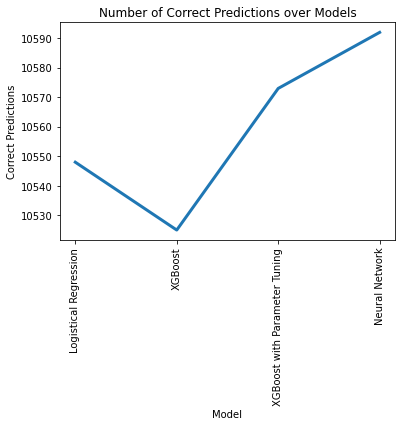

In [76]:
# Plot number of correct predictions for previous models and neural network

x_axis = ["Logistical Regression", "XGBoost", "XGBoost with Parameter Tuning","Neural Network"]
y_axis = [lr_corr_pred, xgb_corr_pred, xgb_tnd_corr_pred,nn_corr_pred]

plt.plot(x_axis,y_axis,linewidth = 3)
plt.xlabel('Model')
plt.ylabel('Correct Predictions')
plt.title('Number of Correct Predictions over Models')
plt.xticks(rotation=90)

# Show the plot
plt.show()

After running this multiple times the neural networks accuracy is a bit variable, potentially due to the early stopping parameter. Most of the time, it's slightly better than XGboost with tunning. That said,we did not seem the same level of difference in accuracy that was observed in the paper (82% vs 79%), however, we may not have the computing resources to add more layers and create a denser neural network.

In [77]:
# Calculate percentage increase in accuracy between the most accurate model and the least accurate

print("The neural network is",round((nn_corr_pred - lr_corr_pred)/diab_df.shape[0] *100,2),"% more accurate than the base model")

The neural network is 0.06 % more accurate than the base model


Though iterative modeling, we've improved the efficacy of our model by around 100 predictions. This represents an increase of around ~0.1%.

# Final Model Evaluation

For the final model, we are recommending our baseline model the logistic regression model for use by the CDC. Even though we iteratively improved the accuracy and precision metrics across the XGB, tuned models, and neural network, the increase in these metrics is not worth the time and resources it takes to train and tune these models.

We only used a small sample of the data available in the study in our training/testing (31K vs 440K records). Deploying this model across data that goes into the hundreds of thousands or millions of records if you consider the previous years data, may not be economical if you consider time, computational resources, and FTEs it takes.

Logistical Regression probably gives the CDC what they need to reasonably determine the likelyhood of diabetes with a limited budget.

In [78]:
measures

,Training Accuracy,Testing Accuracy,Recall,Precision,F1 Score,Roc-AUC Score,Runtime (s)
Logistical Regression,0.744880,0.750694,0.775682,0.737435,0.756075,0.750788,0
Random Forest,0.997135,0.741442,0.784826,0.720866,0.751488,0.741605,9
Decision Tree Classifer,0.997153,0.659526,0.649807,0.660950,0.655331,0.659489,0
XGB Classifier,0.791605,0.749057,0.793542,0.727439,0.759054,0.749224,6
SVC,0.768296,0.751619,0.807830,0.724965,0.764157,0.751830,4194
GaussianNB,0.714542,0.720518,0.709673,0.723841,0.716687,0.720477,0
KNeighbors,0.794932,0.706213,0.731533,0.694803,0.712695,0.706308,309
XGB Tuned 1,0.757727,0.752473,0.801543,0.728666,0.763369,0.752658,30
XGB Tuned 2,0.755752,0.751904,0.801257,0.728028,0.762889,0.752089,12
Neural Network,0.757800,0.753825,0.813688,0.725478,0.767055,0.754050,48


# Recommendations

* The CDC should use the logistical regression model in their application.

* Consider a strategy around educating people to take their blood pressure on a regular basis since it was one of the top features.

* Providers who see people with high cholesterol should also screen for diabetes since high cholesterol was another top feature.

* Continue advocating for policy/strategies that aim to improve the general health and fitness of Americans. Low health was the most correlated feature with diabetes.

# Future Projects

* Evaluate previous BRFSS data sets. Measure the rate of diabetes and other chronic conditions to find their trends across the country.
* Use the model to create an application on the CDC's website that allows a person to enter their data and get a diabetic risk score.
* Further investigate a strategy around making it easier for people to take and track their blood pressure. It was found to be the greatest predictor around diabetes.

# Reproduction Steps



### Download from Github to Local Machine

1. Download the 2015.CSV from this link: https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system
2. Save CSV to file and run steps from the data cleaning <a href="notebooks/Data_Cleaning.ipynb">notebook</a>.
3. Run the main notebook.

### Running on Google Colab

#### If you can only run one notebooks on same runtime
1. Run the colab <a href="colab.ipynb">notebook</a>. first.

#### If you are using google drive
1. Download github repo to google drive
2. Mount your google drive too colab.
3. Open the data_cleaning-colab notebook.
4. 1. Run the data cleaning colab <a href="Data_Cleaning-colab.ipynb">notebook</a>. first (Data_Cleaning-Colab).
5. Run the index file